# FGSM (Fast Gradient Sign Method) tutorial
This example demonstrates how to apply FGSM attack to a LeNet network trained on MNIST dataset. FGSM is a white-box attack which means the attacker has full access to the model including its parameters. In this attack, we simply take advantage of the gradients of the loss with respect to input data. We first apply sign function to the input gradients, scale it, and then add those gradients to the input data to get the perturbed data which will maximize the loss value.

## Train LeNet on MNIST

In [1]:
using Knet
using Taarruz
using Images

In [2]:
include(Knet.dir("data", "mnist.jl"))
Knet.seed!(1)
dtrn, dtst = mnistdata()
lenet = Lenet()
progress!(adam(lenet, repeat(dtrn, 10)))
accuracy(lenet, dtst)

┌ Info: Loading MNIST...
└ @ Main /kuacc/users/ikesen16/.julia/packages/Knet/05UDD/data/mnist.jl:33


7.55e-02  100.00%┣██████████████████████████▉┫ 6000/6000 [00:33/00:33, 184.22i/s]


0.9888

## Abuse the Model
In this part, we measure the accuracy of our model, but we use the examples genearated with FGSM to abuse the model. As you can see, the accuracy drops nearly 50% percentage.

In [3]:
example(x,y,ϵ=0.2,f=lenet) = FGSM(f,ϵ,x,y)[1]
abuse(x,y,ϵ=0.2,f=lenet; o...) = accuracy(f(example(x,y)), y; o...)
abuse(d::Knet.Data, ϵ=0.2, f=lenet) = sum(abuse(x,y,ϵ,f; average=false) for (x,y) in d) / d.length
abuse(dtst)

0.4731

## Visualize Examples
Let's visualize the examples generated by the attack and observe how our model fails.

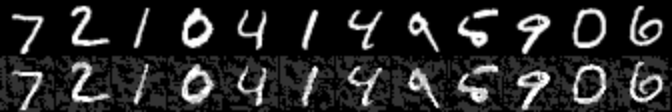

In [4]:
dtst.batchsize = 12 # to get 12 examples
x, y = first(dtst) # use rand to sample random images
ϵ = 0.2
x̂ = FGSM(lenet, ϵ, x, y)[1]
image, noisy = Array(x), Array(x̂)
grid = vcat(
        hcat([mnistview(image, i) for i = 1:length(y)]...),
        hcat([mnistview(noisy, i) for i = 1:length(y)]...))
display(imresize(grid; ratio=2.))

Let's see how good our model performs on the real images and the perturbed images.

In [5]:
predict(x) = map(xi->rem(xi[1],10), argmax(Array(lenet(x)), dims=1))
print("predictions without the attack: "); println(predict(x))
print("predictions with the attack:    "); println(predict(x̂))

predictions without the attack: [7 2 1 0 4 1 4 9 5 9 0 6]
predictions with the attack:    [7 2 8 0 9 7 9 4 6 9 0 0]
